# Statistical Arbitrage: Cointegration Analysis

**Objective:** Identify mean-reverting portfolios using Johansen cointegration testing and VAR eigenvalue decomposition

**Author:** Eduardo  
**Date:** December 2025 
**Status:** Research Phase

---

## Methodology Overview

This notebook implements a three-stage approach to statistical arbitrage:

1. **Discovery (Johansen Test):** Test for cointegration relationships among assets
2. **Optimization (VAR Decomposition):** Find the fastest mean-reverting portfolio
3. **Validation (Stationarity Tests):** Confirm spread characteristics are suitable for trading

### Key Concepts

**Cointegration:** Two or more non-stationary time series that move together in the long run, even if they deviate in the short term.

**Mean Reversion:** The tendency of a spread to return to its historical average.

**Half-Life:** The expected time for a spread to revert halfway to its mean (optimal range: 5-30 days for swing trading).

---

## Understanding the Two Half-Life Approaches

This notebook uses two complementary methods:

### 1. VAR Eigenvalue Decomposition (Cell above)
- **Purpose:** Find optimal portfolio weights
- **Output:** Eigenvector (hedge ratios) and eigenvalue (κ)
- **κ interpretation:** Theoretical mean-reversion speed of the eigenvector portfolio
- **Not used for:** Actual half-life estimation

### 2. OLS on Spread (Cell below)
- **Purpose:** Validate if the spread actually mean-reverts
- **Output:** λ coefficient from regressing Δspread on spread(t-1)
- **Half-life formula:** -ln(2)/λ where λ < 0 indicates mean-reversion
- **Used for:** Trading decisions and strategy parameters

The VAR method tells us *which weights to use*. The OLS method tells us *how fast the resulting spread mean-reverts in practice*.

## 1. Setup and Imports

In [47]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dotenv
import sys
import os
from datetime import datetime, timedelta
import warnings
import importlib
project_root = os.path.abspath('..')
import src.data as data
sys.path.insert(0, project_root)
print(f"Project Root: {project_root}")

importlib.reload(data)

warnings.filterwarnings('ignore')

# Statistical tests
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
from arch.unitroot import VarianceRatio
# Data fetching (custom module)

# Insert the project root into the system path


from src.data import (
    load_cointegration_data, 
    load_pairs_data,
    INDUSTRIALS_MATERIALS,
    FINANCE_REGIONAL,
    TECH_SEMIS,
    FINANCIAL_ETFS,
    ENERGY_OIL,
    GOLD_MINERS,
    OIL_PRODUCERS,
    COKE_PEPSI,
    VISA_MASTERCARD,
    HOME_DEPOT_LOWES,
    TECH_ENERGY

)


# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✓ All imports successful")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Project Root: c:\code\quant_strategies\stat-arb
✓ All imports successful
Analysis Date: 2025-12-04 21:49


## 2. Configuration and Universe Selection

In [48]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Universe Selection
# Options: STAT_ARB_BASKET, TECH_STOCKS, SEMICONDUCTOR_STOCKS, or custom list
UNIVERSE = INDUSTRIALS_MATERIALS # Use first 9 semiconductor stocks

# Data parameters
LOOKBACK_DAYS = 80  
DATA_SOURCE = 'alpaca'  # 'yfinance' or 'alpaca'

# Analysis parameters
SIGNIFICANCE_LEVEL = 0.05  # 5% for statistical tests
MIN_HALF_LIFE = 5   # Minimum half-life in days (too fast = noise)
MAX_HALF_LIFE = 30  # Maximum half-life in days (too slow = unprofitable)

print("="*70)
print("CONFIGURATION")
print("="*70)
print(f"Universe: {len(UNIVERSE)} assets")
print(f"Assets: {UNIVERSE}")
print(f"Lookback: {LOOKBACK_DAYS} days (~{LOOKBACK_DAYS/252:.1f} years)")
print(f"Data Source: {DATA_SOURCE}")
print(f"Significance Level: {SIGNIFICANCE_LEVEL*100}%")
print(f"Tradable Half-Life Range: {MIN_HALF_LIFE}-{MAX_HALF_LIFE} days")

CONFIGURATION
Universe: 2 assets
Assets: ['XLI', 'XLB']
Lookback: 80 days (~0.3 years)
Data Source: alpaca
Significance Level: 5.0%
Tradable Half-Life Range: 5-30 days


## 3. Data Loading and Preprocessing

In [49]:
# Load log prices and validate data quality
log_prices_df, validation = load_cointegration_data(
    tickers=UNIVERSE,
    lookback_days=LOOKBACK_DAYS,
    source=DATA_SOURCE,
    validate=True
)

# Store for later use
clean_log_prices_df = log_prices_df.copy()
n_assets = len(clean_log_prices_df.columns)
n_observations = len(clean_log_prices_df)

print("\n" + "="*70)
print("DATA SUMMARY")
print("="*70)
print(f"Shape: {clean_log_prices_df.shape}")
print(f"Date Range: {clean_log_prices_df.index[0].date()} to {clean_log_prices_df.index[-1].date()}")
print(f"Trading Days: {n_observations}")
print(f"Assets: {n_assets}")

# Display sample
print("\nFirst 5 observations (log prices):")
print(clean_log_prices_df.head())

print("\nLast 5 observations (log prices):")
print(clean_log_prices_df.tail())

Loading data for cointegration analysis...
  Tickers: ['XLI', 'XLB']
  Date range: 2025-09-15 to 2025-12-04
  Target observations: ~80 days

✓ Downloaded and log-transformed: 57 observations

⚠ Data quality check: FAILED
  Insufficient data: 57 < 252

Final dataset:
  Shape: (57, 2)
  Date range: 2025-09-15 04:00:00 to 2025-12-03 05:00:00
  Tickers: ['XLI', 'XLB']

DATA SUMMARY
Shape: (57, 2)
Date Range: 2025-09-15 to 2025-12-03
Trading Days: 57
Assets: 2

First 5 observations (log prices):
                          XLI       XLB
2025-09-15 04:00:00  5.025721  4.510310
2025-09-16 04:00:00  5.022761  4.507337
2025-09-17 04:00:00  5.018339  4.509540
2025-09-18 04:00:00  5.028737  4.508769
2025-09-19 04:00:00  5.030634  4.508769

Last 5 observations (log prices):
                          XLI       XLB
2025-11-26 05:00:00  5.029064  4.487175
2025-11-28 05:00:00  5.034873  4.492897
2025-12-01 05:00:00  5.020586  4.490881
2025-12-02 05:00:00  5.028737  4.481306
2025-12-03 05:00:00  5.038250

### 3.1 Price Visualization

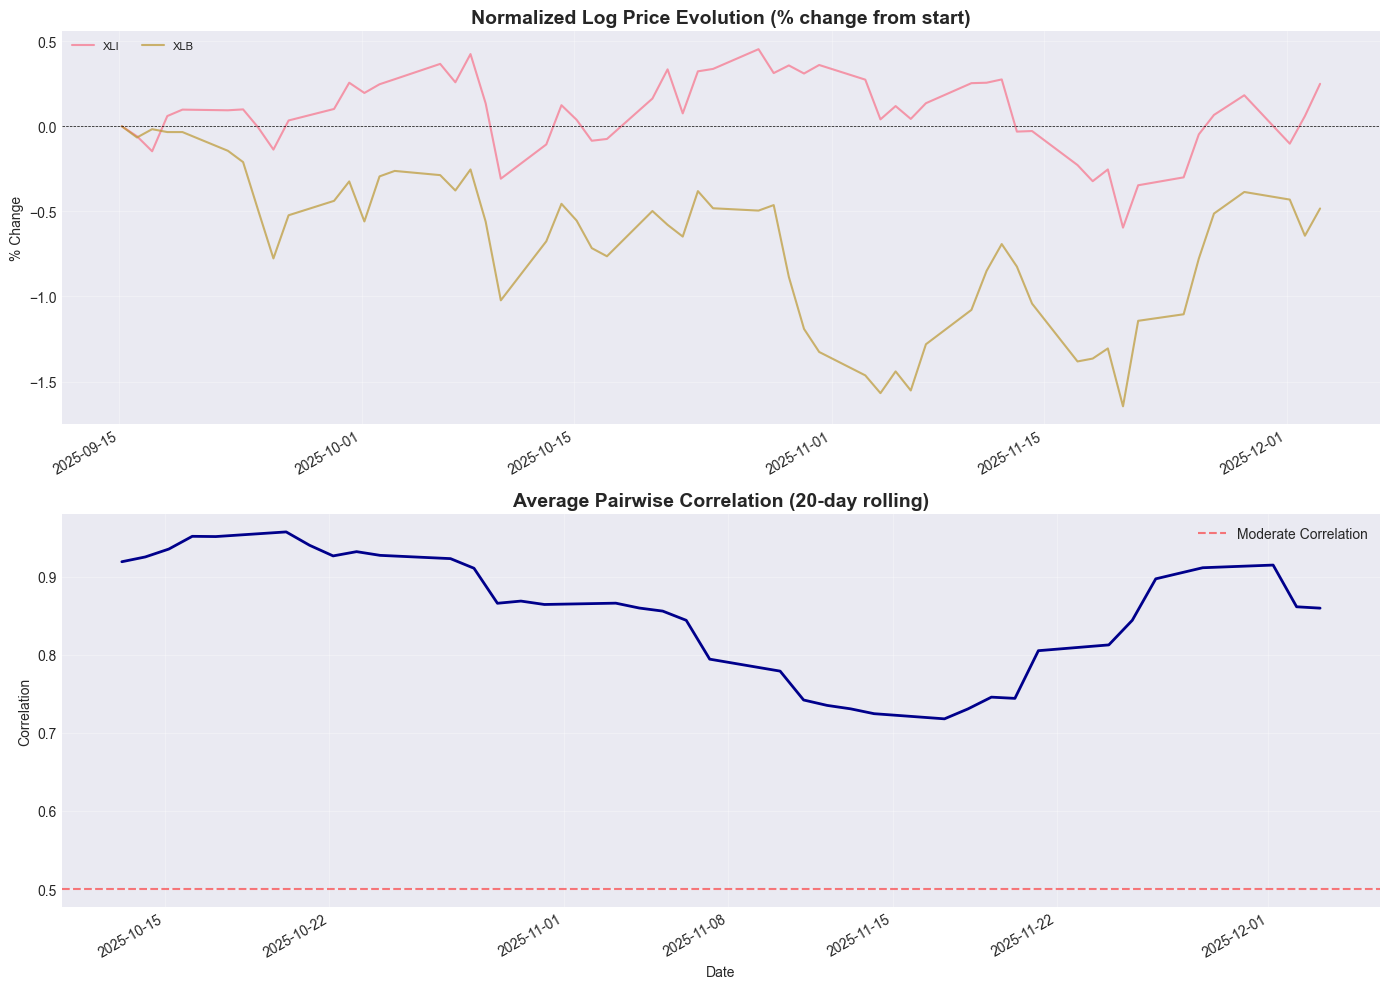


Average correlation: 0.849
Correlation range: [0.698, 1.000]


In [50]:
# Plot normalized log prices
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Subplot 1: Normalized log prices
normalized_prices = (clean_log_prices_df - clean_log_prices_df.iloc[0]) / clean_log_prices_df.iloc[0] * 100
normalized_prices.plot(ax=axes[0], alpha=0.7, linewidth=1.5)
axes[0].set_title('Normalized Log Price Evolution (% change from start)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('% Change')
axes[0].legend(loc='upper left', ncol=3, fontsize=8)
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='black', linestyle='--', linewidth=0.5)

# Subplot 2: Rolling correlation (average pairwise correlation)
returns = clean_log_prices_df.diff().dropna()
rolling_corr = returns.rolling(window=20).corr().groupby(level=0).mean().mean(axis=1)
rolling_corr.plot(ax=axes[1], color='darkblue', linewidth=2)
axes[1].set_title('Average Pairwise Correlation (20-day rolling)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Correlation')
axes[1].set_xlabel('Date')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Moderate Correlation')
axes[1].legend()

plt.tight_layout()
plt.savefig('price_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nAverage correlation: {returns.corr().mean().mean():.3f}")
print(f"Correlation range: [{returns.corr().min().min():.3f}, {returns.corr().max().max():.3f}]")

In [51]:
def calculate_hurst_exponent(ts):
    """Calculate Hurst exponent without nolds dependency."""
    try:
        ts = np.array(ts).flatten()
        N = len(ts)
        if N < 100:
            return 0.5
        
        min_lag = 10
        max_lag = N // 10
        if max_lag <= min_lag:
            return 0.5
        
        lags = np.logspace(np.log10(min_lag), np.log10(max_lag), num=20).astype(int)
        lags = np.unique(lags)
        
        RS = []
        for lag in lags:
            subseries = [ts[i:i+lag] for i in range(0, N-lag+1, lag)]
            rs_values = []
            
            for sub in subseries:
                if len(sub) < lag:
                    continue
                mean_sub = np.mean(sub)
                Y = np.cumsum(sub - mean_sub)
                R = np.max(Y) - np.min(Y)
                S = np.std(sub, ddof=1)
                if S > 0 and R > 0:
                    rs_values.append(R/S)
            
            if rs_values:
                RS.append(np.mean(rs_values))
        
        RS = np.array(RS)
        lags = lags[~np.isnan(RS)]
        RS = RS[~np.isnan(RS)]
        
        if len(RS) < 3:
            return 0.5
        
        H = np.polyfit(np.log(lags), np.log(RS), 1)[0]
        return np.clip(H, 0, 1)
    except:
        return 0.5

print("✓ Custom Hurst exponent loaded (no nolds required)")

✓ Custom Hurst exponent loaded (no nolds required)


## 4. Phase 1: Discovery - Johansen Cointegration Test

The Johansen test determines whether a statistically significant cointegrating relationship exists among the assets.

**Null Hypothesis:** At most r cointegrating relationships exist  
**Alternative:** More than r cointegrating relationships exist

**Test Statistics:**
- **Trace Statistic:** Tests for r cointegrating vectors
- **Max Eigenvalue:** Tests for exactly r vs r+1 vectors

**Decision Rule:** If test statistic > critical value → reject null (cointegration exists)

In [52]:
# ============================================================================
# STEP 1: VAR Lag Order Selection
# ============================================================================

print("="*70)
print("VAR LAG ORDER SELECTION")
print("="*70)

model_var = VAR(clean_log_prices_df)
lag_selection = model_var.select_order(maxlags=10)

print("\nLag Selection Criteria:")
print(lag_selection.summary())

# Use AIC (Akaike Information Criterion) for lag selection
optimal_lag = lag_selection.aic
k_ar_diff = optimal_lag  # For Johansen test

print(f"\n✓ Selected Lag Order: {optimal_lag} (based on AIC)")
print(f"✓ VECM lag parameter (k_ar_diff): {k_ar_diff}")

VAR LAG ORDER SELECTION

Lag Selection Criteria:
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -17.08      -17.00   3.809e-08      -17.05
1      -19.46*     -19.22*  3.543e-09*     -19.37*
2       -19.33      -18.94   4.032e-09      -19.18
3       -19.26      -18.71   4.349e-09      -19.05
4       -19.16      -18.46   4.800e-09      -18.90
5       -19.04      -18.18   5.461e-09      -18.72
6       -19.15      -18.13   4.950e-09      -18.77
7       -19.17      -17.99   4.927e-09      -18.73
8       -19.08      -17.74   5.531e-09      -18.58
9       -19.09      -17.59   5.643e-09      -18.53
10      -19.14      -17.48   5.598e-09      -18.51
--------------------------------------------------

✓ Selected Lag Order: 1 (based on AIC)
✓ VECM lag parameter (k_ar_diff): 1


In [53]:
# ============================================================================
# STEP 2: Johansen Cointegration Test
# ============================================================================

print("\n" + "="*70)
print("JOHANSEN COINTEGRATION TEST")
print("="*70)

# Run Johansen test
# det_order=0: No deterministic trend (assume mean-reverting around zero)
# det_order=1: Constant in cointegrating relation
johansen_result = coint_johansen(clean_log_prices_df, det_order=0, k_ar_diff=k_ar_diff)

# Extract results
trace_stats = johansen_result.lr1  # Trace statistics
trace_crit = johansen_result.cvt  # Critical values [90%, 95%, 99%]
eigen_stats = johansen_result.lr2  # Max eigenvalue statistics
eigen_crit = johansen_result.cvm  # Critical values

# Print results
print(f"\nTest Configuration:")
print(f"  Number of assets: {n_assets}")
print(f"  Observations: {n_observations}")
print(f"  Lag order: {k_ar_diff}")
print(f"  Significance level: {SIGNIFICANCE_LEVEL*100}%")

print("\n" + "-"*70)
print("TRACE TEST RESULTS")
print("-"*70)
print(f"{'Rank':<6} {'Trace Stat':<12} {'Critical (5%)':<15} {'Reject H0?':<12}")
print("-"*70)

n_coint_trace = 0
for i in range(n_assets):
    reject = "YES ✓" if trace_stats[i] > trace_crit[i, 1] else "NO"
    print(f"r≤{i:<4} {trace_stats[i]:<12.2f} {trace_crit[i, 1]:<15.2f} {reject:<12}")
    if trace_stats[i] > trace_crit[i, 1]:
        n_coint_trace = i + 1
    else:
        break # Stop at first non-rejection

print("\n" + "-"*70)
print("MAX EIGENVALUE TEST RESULTS")
print("-"*70)
print(f"{'Rank':<6} {'Max Eigen':<12} {'Critical (5%)':<15} {'Reject H0?':<12}")
print("-"*70)

n_coint_eigen = 0
for i in range(n_assets):
    reject = "YES ✓" if eigen_stats[i] > eigen_crit[i, 1] else "NO"
    print(f"r={i:<5} {eigen_stats[i]:<12.2f} {eigen_crit[i, 1]:<15.2f} {reject:<12}")
    if eigen_stats[i] > eigen_crit[i, 1]:
        n_coint_eigen += 1
    else:
        break

print("\n" + "="*70)
print("COINTEGRATION SUMMARY")
print("="*70)
print(f"Number of cointegrating relationships (Trace Test): {n_coint_trace}")
print(f"Number of cointegrating relationships (Max Eigen): {n_coint_eigen}")

if n_coint_trace > 0 or n_coint_eigen > 0:
    print("\n✓ COINTEGRATION DETECTED - Proceeding with portfolio optimization")
    cointegration_exists = True
else:
    print("\n⚠ NO SIGNIFICANT COINTEGRATION - Consider:")
    print("  1. Different asset universe")
    print("  2. Longer historical period")
    print("  3. Subset of assets (pairs/triplets)")
    cointegration_exists = False

# Store cointegrating vector (first eigenvector)
johansen_coint_vector = johansen_result.evec[:, 0]

print("\nJohansen Cointegrating Vector (First):")
for i, ticker in enumerate(clean_log_prices_df.columns):
    print(f"  {ticker:<8}: {johansen_coint_vector[i]:>8.4f}")


JOHANSEN COINTEGRATION TEST

Test Configuration:
  Number of assets: 2
  Observations: 57
  Lag order: 1
  Significance level: 5.0%

----------------------------------------------------------------------
TRACE TEST RESULTS
----------------------------------------------------------------------
Rank   Trace Stat   Critical (5%)   Reject H0?  
----------------------------------------------------------------------
r≤0    15.16        15.49           NO          

----------------------------------------------------------------------
MAX EIGENVALUE TEST RESULTS
----------------------------------------------------------------------
Rank   Max Eigen    Critical (5%)   Reject H0?  
----------------------------------------------------------------------
r=0     10.54        14.26           NO          

COINTEGRATION SUMMARY
Number of cointegrating relationships (Trace Test): 0
Number of cointegrating relationships (Max Eigen): 0

⚠ NO SIGNIFICANT COINTEGRATION - Consider:
  1. Different asset 

## 5. Phase 2: Optimization - VAR Eigenvalue Decomposition

While Johansen tells us IF cointegration exists, VAR decomposition tells us WHICH portfolio mean-reverts FASTEST.

**Process:**
1. Fit VAR(1): ΔS_t = A + B·S_{t-1} + ε_t
2. Compute mean-reversion matrix: κ = (I - B) / Δt
3. Diagonalize κ = U·Λ·U⁻¹
4. Select portfolio with max|λ| (fastest mean-reversion)

**Key Output:** Optimal hedge ratios that maximize mean-reversion speed

In [54]:
# ============================================================================
# VAR EIGENVALUE DECOMPOSITION
# ============================================================================

print("\n" + "="*70)
print("VAR EIGENVALUE DECOMPOSITION - Portfolio Optimization")
print("="*70)
print("\nNote: This method finds optimal hedge ratios by identifying the")
print("eigenvector with fastest theoretical mean-reversion. The actual")
print("half-life of the resulting spread is validated separately via OLS.")

# Fit VAR(1) model
var_model = VAR(clean_log_prices_df)
var_fit = var_model.fit(maxlags=1)

# Extract coefficient matrix B
# var_fit.params has shape (n_vars*n_lags + const, n_vars)
B_matrix = var_fit.params.iloc[1:n_assets+1, :].values.T  # Transpose for correct orientation


print("\nVAR(1) Coefficient Matrix B:")
B_df = pd.DataFrame(B_matrix, 
                    index=clean_log_prices_df.columns, 
                    columns=clean_log_prices_df.columns)
print(B_df.round(4))

# Compute mean-reversion matrix κ = (I - B) / Δt
dt = 1  # Daily data
I_matrix = np.eye(n_assets)
kappa_matrix = (I_matrix - B_matrix) / dt

print("\nMean-Reversion Matrix κ:")
kappa_df = pd.DataFrame(kappa_matrix,
                        index=clean_log_prices_df.columns,
                        columns=clean_log_prices_df.columns)
print(kappa_df.round(6))

# Diagonalize κ
eigenvalues, eigenvectors = np.linalg.eig(kappa_matrix)
eigenvalues = eigenvalues.real
eigenvectors = eigenvectors.real

# Sort by magnitude (fastest to slowest mean-reversion)
sorted_indices = np.argsort(np.abs(eigenvalues))[::-1]
eigenvalues_sorted = eigenvalues[sorted_indices]
eigenvectors_sorted = eigenvectors[:, sorted_indices]

print("\n" + "-"*70)
print("EIGENVALUE ANALYSIS (Sorted by Mean-Reversion Speed)")
print("-"*70)
print(f"{'Rank':<6} {'Eigenvalue (κ)':<18} {'Interpretation':<30}")
print("-"*70)

eigenvalue_results = []
for i in range(n_assets):
    kappa_i = eigenvalues_sorted[i]
    if kappa_i > 0.1:
        interp = "Fast mean-reversion (use this)"
    elif kappa_i > 0:
        interp = "Slow mean-reversion"
    else:
        interp = "Explosive / Momentum"
    
    eigenvalue_results.append({
        'rank': i+1,
        'eigenvalue': kappa_i
    })
    
    print(f"{i+1:<6} {kappa_i:<18.6f} {interp:<30}")

# Select best portfolio (fastest mean-reversion based on largest κ eigenvalue)
best_portfolio_idx = 0
optimal_hedge_ratios_var = eigenvectors_sorted[:, best_portfolio_idx]
optimal_kappa = eigenvalues_sorted[best_portfolio_idx]
optimal_half_life = -np.log(2) / optimal_kappa if optimal_kappa > 0 else np.inf # theoretical halflife from VAR! not really being used for now!

print("\n" + "="*70)
print("OPTIMAL PORTFOLIO WEIGHTS (Fastest Theoretical Mean-Reversion)")
print("="*70)
print(f"Mean-Reversion Speed (κ eigenvalue): {optimal_kappa:.6f}")
print(f"\nNote: κ is the eigenvalue of the mean-reversion matrix (I - B).")
print("Larger κ indicates faster theoretical mean-reversion for this eigenvector.")
print("The actual tradable half-life will be computed via OLS on the spread.")

print("\nOptimal Hedge Ratios (VAR Decomposition):")
for i, ticker in enumerate(clean_log_prices_df.columns):
    print(f"  {ticker:<8}: {optimal_hedge_ratios_var[i]:>8.4f}")

# Normalize for interpretation (relative to first asset)
normalized_var_ratios = optimal_hedge_ratios_var / optimal_hedge_ratios_var[0]
print(f"\nNormalized Ratios (relative to {clean_log_prices_df.columns[0]}):")
for i, ticker in enumerate(clean_log_prices_df.columns):
    print(f"  {ticker:<8}: {normalized_var_ratios[i]:>8.4f}")


VAR EIGENVALUE DECOMPOSITION - Portfolio Optimization

Note: This method finds optimal hedge ratios by identifying the
eigenvector with fastest theoretical mean-reversion. The actual
half-life of the resulting spread is validated separately via OLS.

VAR(1) Coefficient Matrix B:
        XLI     XLB
XLI  0.7066  0.0311
XLB -0.2881  0.9232

Mean-Reversion Matrix κ:
          XLI       XLB
XLI  0.293405 -0.031115
XLB  0.288148  0.076797

----------------------------------------------------------------------
EIGENVALUE ANALYSIS (Sorted by Mean-Reversion Speed)
----------------------------------------------------------------------
Rank   Eigenvalue (κ)     Interpretation                
----------------------------------------------------------------------
1      0.237675           Fast mean-reversion (use this)
2      0.132527           Fast mean-reversion (use this)

OPTIMAL PORTFOLIO WEIGHTS (Fastest Theoretical Mean-Reversion)
Mean-Reversion Speed (κ eigenvalue): 0.237675

Note: κ is t

## 6. Comparison: Johansen vs VAR Decomposition

Both methods produce hedge ratios, but through different approaches:
- **Johansen:** Tests for cointegration existence (statistical significance)
- **VAR Decomposition:** Optimizes for mean-reversion speed (profitability)

The differences reveal whether statistical significance aligns with trading profitability.


COMPARING JOHANSEN vs VAR DECOMPOSITION

Hedge Ratios Comparison (Normalized):
     Johansen  VAR Decomp  Difference  Abs Diff
XLI    1.0000      1.0000      0.0000    0.0000
XLB    0.3857      1.7911     -1.4054    1.4054

Mean Absolute Difference: 0.7027
Max Absolute Difference: 1.4054

⚠ Moderate disagreement between methods
  Recommendation: Validate both spreads with stationarity tests


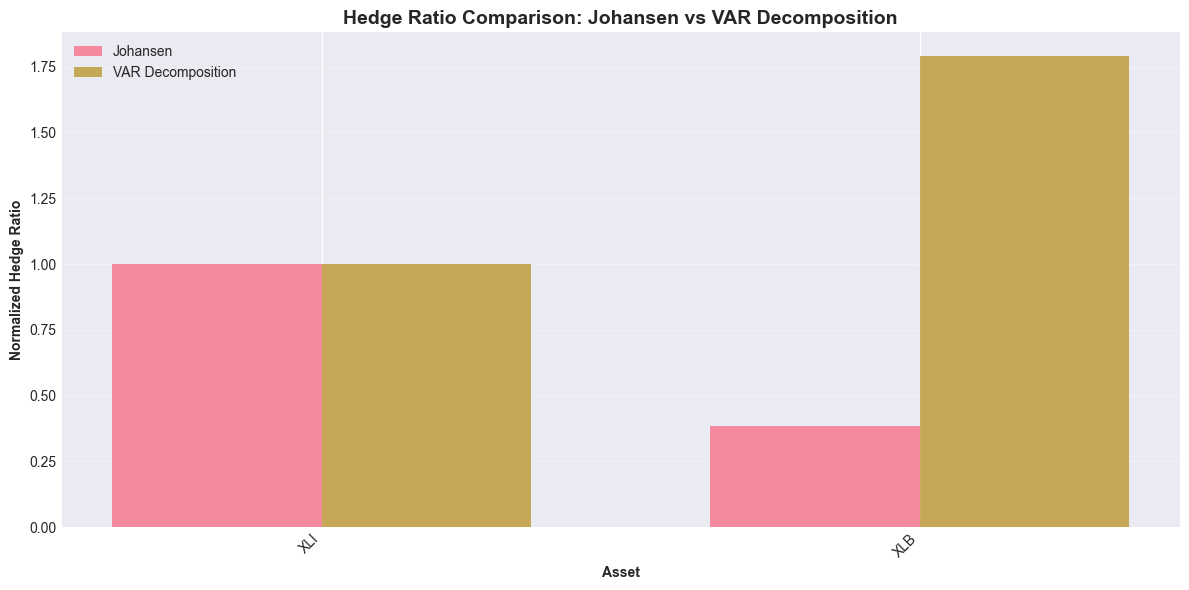

In [55]:
# ============================================================================
# COMPARISON: Johansen vs VAR
# ============================================================================

print("\n" + "="*70)
print("COMPARING JOHANSEN vs VAR DECOMPOSITION")
print("="*70)

# Normalize both for comparison (relative to first asset)
johansen_normalized = johansen_coint_vector / johansen_coint_vector[0]
var_normalized = normalized_var_ratios

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Johansen': johansen_normalized,
    'VAR Decomp': var_normalized,
    'Difference': johansen_normalized - var_normalized,
    'Abs Diff': np.abs(johansen_normalized - var_normalized)
}, index=clean_log_prices_df.columns)

print("\nHedge Ratios Comparison (Normalized):")
print(comparison_df.round(4))

mean_abs_diff = comparison_df['Abs Diff'].mean()
max_abs_diff = comparison_df['Abs Diff'].max()

print(f"\nMean Absolute Difference: {mean_abs_diff:.4f}")
print(f"Max Absolute Difference: {max_abs_diff:.4f}")

if mean_abs_diff < 0.5:
    print("\n✓ Methods agree reasonably well")
    print("  Interpretation: Statistical cointegration aligns with mean-reversion dynamics")
elif mean_abs_diff < 1.0:
    print("\n⚠ Moderate disagreement between methods")
    print("  Recommendation: Validate both spreads with stationarity tests")
else:
    print("\n⚠ Significant disagreement between methods")
    print("  Recommendation: VAR decomposition likely more reliable for trading")

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.35

ax.bar(x - width/2, comparison_df['Johansen'], width, label='Johansen', alpha=0.8)
ax.bar(x + width/2, comparison_df['VAR Decomp'], width, label='VAR Decomposition', alpha=0.8)

ax.set_xlabel('Asset', fontweight='bold')
ax.set_ylabel('Normalized Hedge Ratio', fontweight='bold')
ax.set_title('Hedge Ratio Comparison: Johansen vs VAR Decomposition', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df.index, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.savefig('hedge_ratio_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Phase 3: Validation - Stationarity Tests

We must validate that the constructed spreads are actually mean-reverting and suitable for trading.

**Tests Applied:**
1. **ADF (Augmented Dickey-Fuller):** Tests for unit root (non-stationarity)
2. **KPSS:** Tests for stationarity (complementary to ADF)
3. **Variance Ratio:** Tests for mean-reversion vs momentum
4. **Hurst Exponent:** Measures long-term memory (H < 0.5 = mean-reverting)
5. **Half-Life:** Expected time to revert halfway to mean

In [56]:
# ============================================================================
# STATIONARITY VALIDATION
# ============================================================================

def comprehensive_stationarity_tests(spread, method_name):
    """
    Run comprehensive stationarity tests on a spread.
    
    The half-life here is computed via OLS regression of Δspread on spread(t-1),
    which is the standard Ornstein-Uhlenbeck calibration method (Ernie Chan).
    This measures the ACTUAL mean-reversion speed of the constructed spread,
    as opposed to the theoretical eigenvalue from VAR decomposition.
    
    Returns: dict with test results
    """
    results = {'method': method_name}
    
    # 1. ADF Test
    adf_stat, adf_p, _, _, _, _ = adfuller(spread)
    results['adf_stat'] = adf_stat
    results['adf_pval'] = adf_p
    results['adf_stationary'] = adf_p < SIGNIFICANCE_LEVEL
    
    # 2. KPSS Test
    kpss_stat, kpss_p, _, _ = kpss(spread, regression='c', nlags='auto')
    results['kpss_stat'] = kpss_stat
    results['kpss_pval'] = kpss_p
    results['kpss_stationary'] = kpss_p > SIGNIFICANCE_LEVEL
    
    # 3. Variance Ratio Test
    vr = VarianceRatio(spread, lags=8)
    results['var_ratio'] = vr.stat
    results['var_ratio_pval'] = vr.pvalue
    results['var_ratio_mr'] = vr.stat < 1  # < 1 suggests mean-reversion
    
    # 4. Hurst Exponent (UPDATED LINE)
    # Replaced 'nolds.hurst_rs' with your custom function
    H = calculate_hurst_exponent(spread.values)
    results['hurst'] = H
    results['hurst_mr'] = H < 0.5  # < 0.5 indicates mean-reversion
    
    # 5. Half-Life
    spread_diff = np.diff(spread)
    spread_lagged = spread[:-1]
    ols_model = sm.OLS(spread_diff, sm.add_constant(spread_lagged)).fit()
    lambda_param = ols_model.params[1]
    half_life = -np.log(2) / lambda_param if lambda_param < 0 else np.inf
    results['half_life'] = half_life
    results['half_life_tradable'] = MIN_HALF_LIFE < half_life < MAX_HALF_LIFE
    
    # Overall score (0-5)
    score = sum([
        results['adf_stationary'],
        results['kpss_stationary'],
        results['var_ratio_mr'],
        results['hurst_mr'],
        results['half_life_tradable']
    ])
    results['score'] = score
    
    return results

# Create spreads using both methods
spread_johansen = clean_log_prices_df @ johansen_coint_vector
spread_var = clean_log_prices_df @ optimal_hedge_ratios_var

print("\n" + "="*70)
print("STATIONARITY VALIDATION - JOHANSEN SPREAD")
print("="*70)

johansen_tests = comprehensive_stationarity_tests(spread_johansen, "Johansen")

print(f"\n1. ADF Test (Unit Root):")
print(f"   Statistic: {johansen_tests['adf_stat']:.4f}")
print(f"   P-value: {johansen_tests['adf_pval']:.4f}")
print(f"   Result: {'✓ Stationary' if johansen_tests['adf_stationary'] else '✗ Non-stationary'}")

print(f"\n2. KPSS Test (Stationarity):")
print(f"   Statistic: {johansen_tests['kpss_stat']:.4f}")
print(f"   P-value: {johansen_tests['kpss_pval']:.4f}")
print(f"   Result: {'✓ Stationary' if johansen_tests['kpss_stationary'] else '✗ Non-stationary'}")

print(f"\n3. Variance Ratio Test:")
print(f"   Statistic: {johansen_tests['var_ratio']:.4f}")
print(f"   P-value: {johansen_tests['var_ratio_pval']:.4f}")
print(f"   Result: {'✓ Mean-reverting' if johansen_tests['var_ratio_mr'] else '✗ Momentum/Random'}")

print(f"\n4. Hurst Exponent:")
print(f"   Value: {johansen_tests['hurst']:.4f}")
print(f"   Result: {'✓ Mean-reverting' if johansen_tests['hurst_mr'] else '✗ Trending/Persistent'}")

print(f"\n5. Half-Life:")
print(f"   Value: {johansen_tests['half_life']:.2f} days")
print(f"   Result: {'✓ Tradable' if johansen_tests['half_life_tradable'] else '✗ Not tradable'}")

print(f"\nOverall Score: {johansen_tests['score']}/5")

print("\n" + "="*70)
print("STATIONARITY VALIDATION - VAR DECOMPOSITION SPREAD")
print("="*70)

var_tests = comprehensive_stationarity_tests(spread_var, "VAR Decomposition")

print(f"\n1. ADF Test (Unit Root):")
print(f"   Statistic: {var_tests['adf_stat']:.4f}")
print(f"   P-value: {var_tests['adf_pval']:.4f}")
print(f"   Result: {'✓ Stationary' if var_tests['adf_stationary'] else '✗ Non-stationary'}")

print(f"\n2. KPSS Test (Stationarity):")
print(f"   Statistic: {var_tests['kpss_stat']:.4f}")
print(f"   P-value: {var_tests['kpss_pval']:.4f}")
print(f"   Result: {'✓ Stationary' if var_tests['kpss_stationary'] else '✗ Non-stationary'}")

print(f"\n3. Variance Ratio Test:")
print(f"   Statistic: {var_tests['var_ratio']:.4f}")
print(f"   P-value: {var_tests['var_ratio_pval']:.4f}")
print(f"   Result: {'✓ Mean-reverting' if var_tests['var_ratio_mr'] else '✗ Momentum/Random'}")

print(f"\n4. Hurst Exponent:")
print(f"   Value: {var_tests['hurst']:.4f}")
print(f"   Result: {'✓ Mean-reverting' if var_tests['hurst_mr'] else '✗ Trending/Persistent'}")

print(f"\n5. Half-Life:")
print(f"   Value: {var_tests['half_life']:.2f} days")
print(f"   Result: {'✓ Tradable' if var_tests['half_life_tradable'] else '✗ Not tradable'}")

print(f"\nOverall Score: {var_tests['score']}/5")

# Comparison
print("\n" + "="*70)
print("WINNER DETERMINATION")
print("="*70)

if var_tests['score'] > johansen_tests['score']:
    print("\n🏆 WINNER: VAR Decomposition")
    print(f"   Score: {var_tests['score']}/5 vs {johansen_tests['score']}/5")
    best_method = "VAR Decomposition"
    best_hedge_ratios = optimal_hedge_ratios_var
    best_spread = spread_var
    best_half_life = var_tests['half_life']
elif johansen_tests['score'] > var_tests['score']:
    print("\n🏆 WINNER: Johansen")
    print(f"   Score: {johansen_tests['score']}/5 vs {var_tests['score']}/5")
    best_method = "Johansen"
    best_hedge_ratios = johansen_coint_vector
    best_spread = spread_johansen
    best_half_life = johansen_tests['half_life']
else:
    print("\n🤝 TIE: Both methods perform equally")
    print(f"   Score: {var_tests['score']}/5")
    print("   Recommendation: Use VAR (optimizes for speed)")
    best_method = "VAR Decomposition"
    best_hedge_ratios = optimal_hedge_ratios_var
    best_spread = spread_var
    best_half_life = var_tests['half_life']

print(f"\nRecommended Hedge Ratios ({best_method}):")
for i, ticker in enumerate(clean_log_prices_df.columns):
    print(f"  {ticker:<8}: {best_hedge_ratios[i]:>8.4f}")


STATIONARITY VALIDATION - JOHANSEN SPREAD

1. ADF Test (Unit Root):
   Statistic: -2.7759
   P-value: 0.0618
   Result: ✗ Non-stationary

2. KPSS Test (Stationarity):
   Statistic: 0.4341
   P-value: 0.0624
   Result: ✓ Stationary

3. Variance Ratio Test:
   Statistic: -0.8195
   P-value: 0.4125
   Result: ✓ Mean-reverting

4. Hurst Exponent:
   Value: 0.5000
   Result: ✗ Trending/Persistent

5. Half-Life:
   Value: 2.74 days
   Result: ✗ Not tradable

Overall Score: 2/5

STATIONARITY VALIDATION - VAR DECOMPOSITION SPREAD

1. ADF Test (Unit Root):
   Statistic: -2.3505
   P-value: 0.1562
   Result: ✗ Non-stationary

2. KPSS Test (Stationarity):
   Statistic: 0.6606
   P-value: 0.0171
   Result: ✗ Non-stationary

3. Variance Ratio Test:
   Statistic: -0.5326
   P-value: 0.5943
   Result: ✓ Mean-reverting

4. Hurst Exponent:
   Value: 0.5000
   Result: ✗ Trending/Persistent

5. Half-Life:
   Value: 3.99 days
   Result: ✗ Not tradable

Overall Score: 1/5

WINNER DETERMINATION

🏆 WINNER: 

## 8. Spread Analysis and Visualization

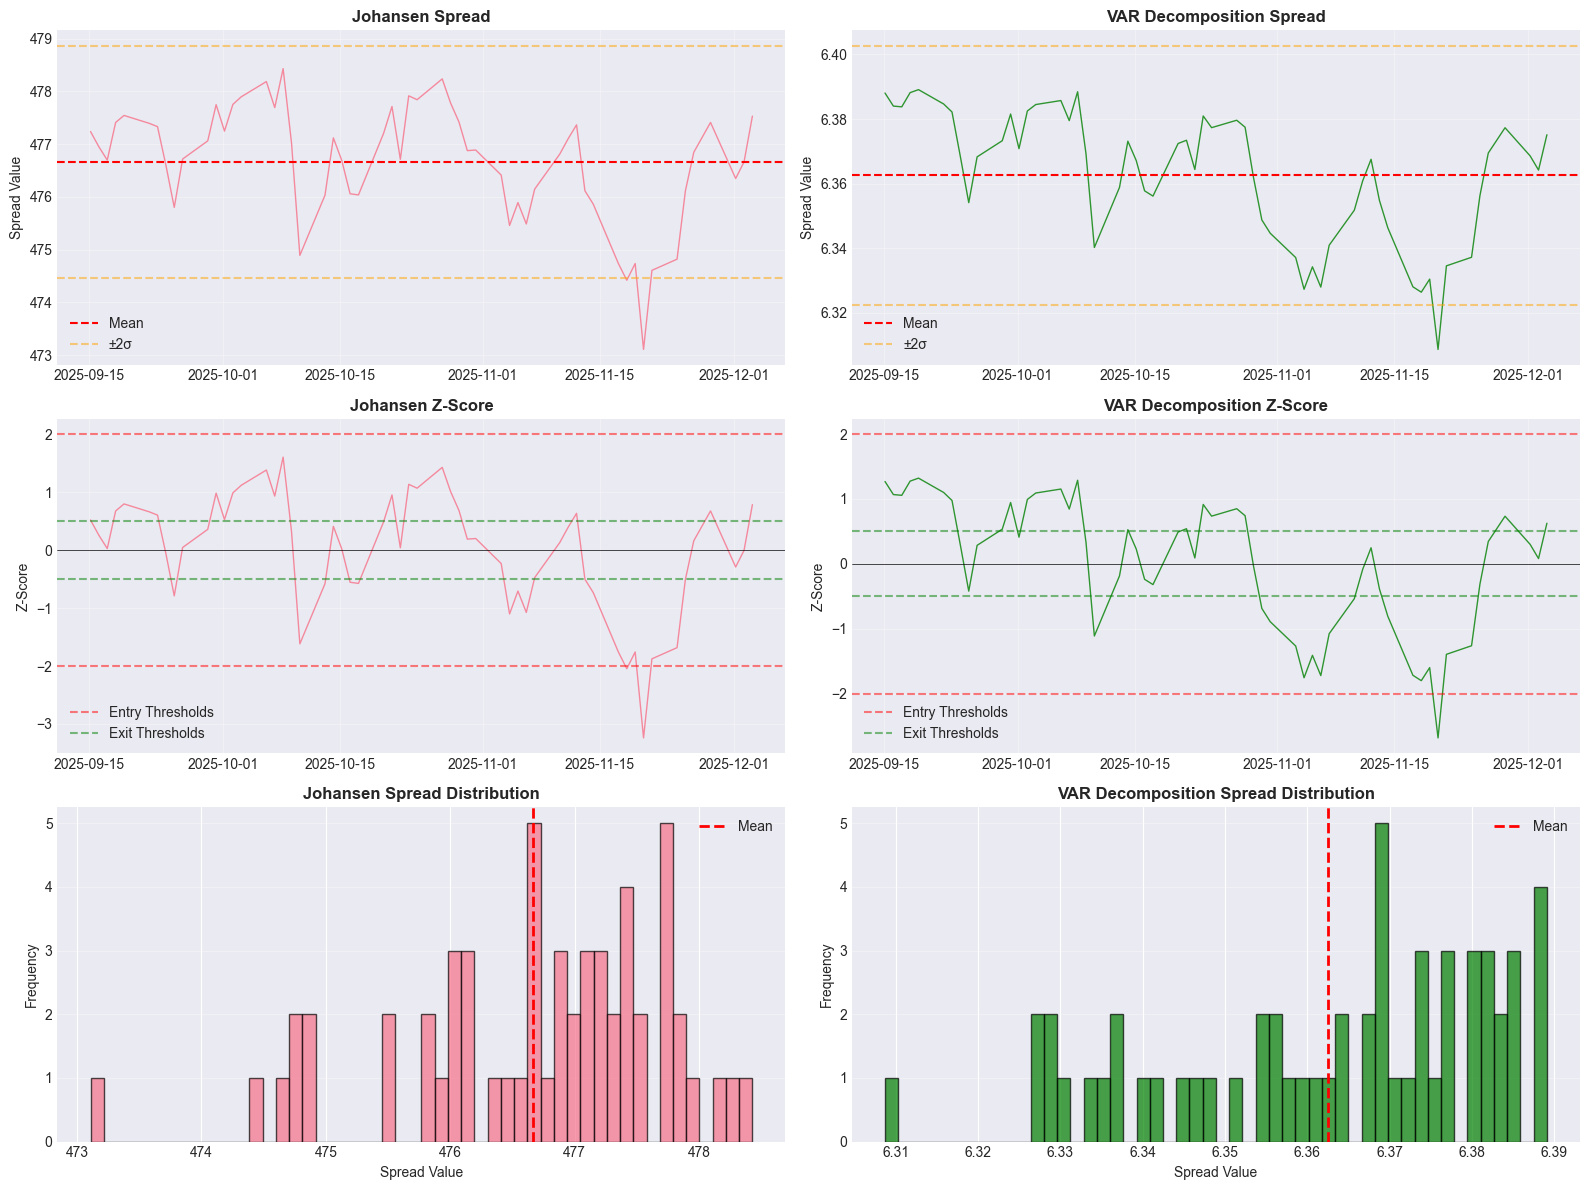


✓ Spread analysis plots saved as 'spread_analysis.png'


In [57]:
# ============================================================================
# SPREAD VISUALIZATION
# ============================================================================

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Johansen Spread
spread_j_mean = spread_johansen.mean()
spread_j_std = spread_johansen.std()

axes[0, 0].plot(spread_johansen.index, spread_johansen, linewidth=1, alpha=0.8)
axes[0, 0].axhline(spread_j_mean, color='red', linestyle='--', label='Mean')
axes[0, 0].axhline(spread_j_mean + 2*spread_j_std, color='orange', linestyle='--', alpha=0.5, label='±2σ')
axes[0, 0].axhline(spread_j_mean - 2*spread_j_std, color='orange', linestyle='--', alpha=0.5)
axes[0, 0].set_title('Johansen Spread', fontweight='bold')
axes[0, 0].set_ylabel('Spread Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# VAR Spread
spread_v_mean = spread_var.mean()
spread_v_std = spread_var.std()

axes[0, 1].plot(spread_var.index, spread_var, linewidth=1, alpha=0.8, color='green')
axes[0, 1].axhline(spread_v_mean, color='red', linestyle='--', label='Mean')
axes[0, 1].axhline(spread_v_mean + 2*spread_v_std, color='orange', linestyle='--', alpha=0.5, label='±2σ')
axes[0, 1].axhline(spread_v_mean - 2*spread_v_std, color='orange', linestyle='--', alpha=0.5)
axes[0, 1].set_title('VAR Decomposition Spread', fontweight='bold')
axes[0, 1].set_ylabel('Spread Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Z-scores
z_score_j = (spread_johansen - spread_j_mean) / spread_j_std
z_score_v = (spread_var - spread_v_mean) / spread_v_std

axes[1, 0].plot(z_score_j.index, z_score_j, linewidth=1, alpha=0.8)
axes[1, 0].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[1, 0].axhline(2, color='red', linestyle='--', alpha=0.5, label='Entry Thresholds')
axes[1, 0].axhline(-2, color='red', linestyle='--', alpha=0.5)
axes[1, 0].axhline(0.5, color='green', linestyle='--', alpha=0.5, label='Exit Thresholds')
axes[1, 0].axhline(-0.5, color='green', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Johansen Z-Score', fontweight='bold')
axes[1, 0].set_ylabel('Z-Score')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(z_score_v.index, z_score_v, linewidth=1, alpha=0.8, color='green')
axes[1, 1].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[1, 1].axhline(2, color='red', linestyle='--', alpha=0.5, label='Entry Thresholds')
axes[1, 1].axhline(-2, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axhline(0.5, color='green', linestyle='--', alpha=0.5, label='Exit Thresholds')
axes[1, 1].axhline(-0.5, color='green', linestyle='--', alpha=0.5)
axes[1, 1].set_title('VAR Decomposition Z-Score', fontweight='bold')
axes[1, 1].set_ylabel('Z-Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Distributions
axes[2, 0].hist(spread_johansen, bins=50, alpha=0.7, edgecolor='black')
axes[2, 0].axvline(spread_j_mean, color='red', linestyle='--', linewidth=2, label='Mean')
axes[2, 0].set_title('Johansen Spread Distribution', fontweight='bold')
axes[2, 0].set_xlabel('Spread Value')
axes[2, 0].set_ylabel('Frequency')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3, axis='y')

axes[2, 1].hist(spread_var, bins=50, alpha=0.7, edgecolor='black', color='green')
axes[2, 1].axvline(spread_v_mean, color='red', linestyle='--', linewidth=2, label='Mean')
axes[2, 1].set_title('VAR Decomposition Spread Distribution', fontweight='bold')
axes[2, 1].set_xlabel('Spread Value')
axes[2, 1].set_ylabel('Frequency')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('spread_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Spread analysis plots saved as 'spread_analysis.png'")

## 9. Research Summary and Recommendations

In [58]:
# ============================================================================
# FINAL SUMMARY
# ============================================================================

print("\n" + "="*70)
print("RESEARCH SUMMARY")
print("="*70)

print(f"\n1. Universe: {len(UNIVERSE)} assets")
print(f"   Assets: {UNIVERSE}")

print(f"\n2. Data Quality:")
print(f"   Observations: {n_observations}")
print(f"   Date Range: {clean_log_prices_df.index[0].date()} to {clean_log_prices_df.index[-1].date()}")
print(f"   Missing Data: None")

print(f"\n3. Cointegration Test (Johansen):")
print(f"   Cointegrating Relationships: {n_coint_trace} (Trace) / {n_coint_eigen} (Max Eigen)")
print(f"   Significance: {'✓ Detected' if cointegration_exists else '✗ Not detected'}")

print(f"\n4. VAR Decomposition (Portfolio Weight Selection):")
print(f"   Optimal κ eigenvalue: {optimal_kappa:.6f}")
print(f"   (Note: This is the theoretical mean-reversion speed of the eigenvector)")
print(f"   (Actual half-life validated via OLS below)")

print(f"\n5. Validation Results:")
print(f"   Johansen Score: {johansen_tests['score']}/5")
print(f"   VAR Score: {var_tests['score']}/5")
print(f"   Winner: {best_method}")

print(f"\n6. Recommended Strategy Parameters:")
print(f"   Method: {best_method}")
print(f"   Half-Life: {best_half_life:.2f} days")
print(f"   Expected Holding Period: {best_half_life * 1.5:.0f}-{best_half_life * 3:.0f} days")
print(f"   Rebalancing Frequency: Weekly")

print("\n7. Next Steps:")
if best_half_life < MIN_HALF_LIFE:
    print("   ⚠ Half-life too short (< 5 days)")
    print("   → May be trading noise rather than true mean-reversion")
    print("   → Consider: Longer data lookback, different universe")
elif best_half_life > MAX_HALF_LIFE:
    print("   ⚠ Half-life too long (> 30 days)")
    print("   → Mean-reversion too slow for profitable trading")
    print("   → Consider: More correlated assets, pairs instead of baskets")
else:
    print("   ✓ Half-life in tradable range")
    print("   → Proceed to backtesting")
    print("   → Implement static strategy first (no Kalman)")
    print("   → Add Kalman filter if drawdowns > 15%")

print(f"\n8. Risk Warnings:")
if johansen_tests['score'] < 3 or var_tests['score'] < 3:
    print("   ⚠ Low validation scores suggest weak mean-reversion")
    print("   ⚠ Strategy may have high drawdowns in live trading")
if not cointegration_exists:
    print("   ⚠ No statistical cointegration detected")
    print("   ⚠ Relationship may be spurious")

print("\n" + "="*70)
print("END OF RESEARCH")
print("="*70)


RESEARCH SUMMARY

1. Universe: 2 assets
   Assets: ['XLI', 'XLB']

2. Data Quality:
   Observations: 57
   Date Range: 2025-09-15 to 2025-12-03
   Missing Data: None

3. Cointegration Test (Johansen):
   Cointegrating Relationships: 0 (Trace) / 0 (Max Eigen)
   Significance: ✗ Not detected

4. VAR Decomposition (Portfolio Weight Selection):
   Optimal κ eigenvalue: 0.237675
   (Note: This is the theoretical mean-reversion speed of the eigenvector)
   (Actual half-life validated via OLS below)

5. Validation Results:
   Johansen Score: 2/5
   VAR Score: 1/5
   Winner: Johansen

6. Recommended Strategy Parameters:
   Method: Johansen
   Half-Life: 2.74 days
   Expected Holding Period: 4-8 days
   Rebalancing Frequency: Weekly

7. Next Steps:
   ⚠ Half-life too short (< 5 days)
   → May be trading noise rather than true mean-reversion
   → Consider: Longer data lookback, different universe

8. Risk Warnings:
   ⚠ Low validation scores suggest weak mean-reversion
   ⚠ Strategy may have hi

## 10. Export Results for Strategy Implementation

In [59]:
# Export results for use in strategy implementation
results_summary = {
    'universe': UNIVERSE,
    'n_observations': n_observations,
    'date_range': {
        'start': str(clean_log_prices_df.index[0].date()),
        'end': str(clean_log_prices_df.index[-1].date())
    },
    'cointegration': {
        'exists': cointegration_exists,
        'n_vectors_trace': int(n_coint_trace),
        'n_vectors_eigen': int(n_coint_eigen)
    },
    'optimal_portfolio': {
        'method': best_method,
        'hedge_ratios': dict(zip(clean_log_prices_df.columns, best_hedge_ratios.tolist())),
        'half_life_days': float(best_half_life),  # OLS-based (tradable estimate)
        'var_kappa_eigenvalue': float(optimal_kappa)  # Theoretical (for reference)
    },
    'validation': {
        'johansen_score': int(johansen_tests['score']),
        'var_score': int(var_tests['score']),
        'adf_pvalue': float(var_tests['adf_pval']),
        'hurst_exponent': float(var_tests['hurst'])
    },
    'trading_parameters': {
        'entry_z_score': 2.0,
        'exit_z_score': 0.5,
        'expected_holding_days': int(best_half_life * 2),
        'rebalance_frequency': 'weekly'
    }
}

# Save to JSON
import json
with open('cointegration_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("✓ Results exported to 'cointegration_results.json'")

# Save spreads for backtesting
spread_data = pd.DataFrame({
    'johansen_spread': spread_johansen,
    'var_spread': spread_var,
    'johansen_z_score': z_score_j,
    'var_z_score': z_score_v
})
spread_data.to_csv('spreads_for_backtest.csv')

print("✓ Spreads exported to 'spreads_for_backtest.csv'")
print("\n✓ Research complete! Ready for strategy implementation.")

✓ Results exported to 'cointegration_results.json'
✓ Spreads exported to 'spreads_for_backtest.csv'

✓ Research complete! Ready for strategy implementation.
